In [ ]:
# Install all required packages for this notebook
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost PyWavelets imblearn
import pandas as pd
import numpy as np

#should i normalize?
#featureselection
#length and position of cracks

df = pd.read_csv('/content/CF_combined_dataset_Temp.csv')

# Find rows where any value is NaN
rows_with_nan = df[df.isna().any(axis=1)]

# Print the rows
rows_with_nan
df=df.dropna( )
#df=df.drop(columns=['filepath'])
rows_with_nan = df[df.isna().any(axis=1)]

# Print the rows
rows_with_nan

,Frequency,Real,Imaginary,Magnitude,Crack Status,Temperature


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import xgboost as xgb
from scipy.stats import variation, skew, kurtosis, zscore
from scipy.signal import find_peaks, welch, savgol_filter
from sklearn.preprocessing import (LabelEncoder, RobustScaler,
                                 FunctionTransformer, QuantileTransformer)
from sklearn.decomposition import FastICA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            balanced_accuracy_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from sklearn.covariance import EmpiricalCovariance

# ----------------------- #
# 🌡️ Temperature Utilities
def get_temp_col_index(df, temp_col_name="Temperature"):
    """Safely locate temperature column with validation"""
    try:
        idx = df.columns.get_loc(temp_col_name)
        temp_values = df.iloc[:, idx]
        print(f" Detected temperature column '{temp_col_name}' (index {idx})")
        print(f" Temperature stats - Min: {temp_values.min():.2f}, Max: {temp_values.max():.2f}, "
              f"Median: {temp_values.median():.2f}")
        return idx
    except:
        print(f" Warning: Column '{temp_col_name}' not found. Proceeding without temperature compensation.")
        return None

def safe_temperature_features(temp_vector):
    """Create robust temperature-derived features"""
    temp = np.nan_to_num(temp_vector)
    temp_pos = np.where(temp > 0, temp, np.nanmedian(temp[temp > 0]))

    # Enhanced temperature features
    temp_norm = (temp - np.nanmean(temp)) / (np.nanstd(temp) + 1e-10)
    return np.column_stack([
    temp_norm,  # Normalized temperature
    np.where(temp > 0, np.log(temp_pos), -10),  # Log-scale
    np.sign(temp_norm) * np.sqrt(np.abs(temp_norm)),  # Signed root
    np.sin(2*np.pi*(temp - np.nanmin(temp))/(np.nanmax(temp) - np.nanmin(temp) + 1e-10)),  # Cyclical
    (temp > np.nanmedian(temp)).astype(float)  # Binary threshold
])

# --- Outlier Removal Utility ---
def remove_outliers_iqr(X, threshold=1):
    # Remove/cap outliers using IQR for each feature (column-wise)
    X_clean = np.copy(X)
    for col in range(X.shape[1]):
        q1 = np.percentile(X[:, col], 25)
        q3 = np.percentile(X[:, col], 75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        X_clean[:, col] = np.clip(X[:, col], lower, upper)
    return X_clean

# --- Noise Reduction Utility ---
def apply_savgol_filter(X, window_length=5, polyorder=2):
    # Apply Savitzky-Golay filter to each row (signal)
    X_filtered = np.copy(X)
    for i in range(X.shape[0]):
        try:
            wl = min(window_length, X.shape[1]//2*2+1)
            if wl < 3: wl = 3
            X_filtered[i] = savgol_filter(X[i], window_length=wl, polyorder=polyorder)
        except:
            pass
    return X_filtered

# --- Data Augmentation Utility ---
def add_gaussian_noise(X, std=0.01):
    return X + np.random.normal(0, std, X.shape)

def enhanced_feature_extractor(X, temp_col_index=None, use_filter=True, augment_noise=False, remove_outliers=True):
    # Outlier removal (before smoothing)
    if remove_outliers:
      X = remove_outliers_iqr(X)
    # Optionally apply Savitzky-Golay filter
    if use_filter:
      X = apply_savgol_filter(X)
    if augment_noise:
      X = add_gaussian_noise(X)

    temp_features = None
    if temp_col_index is not None:
        temp_data = X[:, temp_col_index]
        X = np.delete(X, temp_col_index, axis=1)
        temp_features = safe_temperature_features(temp_data)

    # Spectral features with error handling
    with np.errstate(all='ignore'):
        psd = np.abs(np.fft.fft(np.nan_to_num(X)))**2
        freqs = np.fft.fftfreq(X.shape[1])

    # Peak-based features
    band_features = []
    for spectrum in psd:
        spectrum = np.nan_to_num(spectrum)
        try:
            peaks, _ = find_peaks(spectrum, distance=20, prominence=np.nanmedian(spectrum))
            n_peaks = min(3, len(peaks))
            ratios = peaks[1:n_peaks+1]/peaks[:n_peaks] if len(peaks) > 1 else np.zeros(3)
            heights = spectrum[peaks[1:n_peaks+1]]/spectrum[peaks[:n_peaks]] if len(peaks) > 1 else np.zeros(3)
        except:
            ratios = heights = np.zeros(3)

        band_features.append(np.concatenate([
            np.nan_to_num(ratios),
            np.nan_to_num(heights),
            [len(peaks) if 'peaks' in locals() else 0]
        ]))

    # Time-domain statistics + percentiles
    percentiles = [10, 25, 75, 90]
    stats_features = np.column_stack([
        variation(np.nan_to_num(X), axis=1, nan_policy='omit'),
        skew(np.nan_to_num(X), axis=1, nan_policy='omit'),
        kurtosis(np.nan_to_num(X), axis=1, nan_policy='omit'),
        np.nanmedian(X, axis=1),
        np.nanmax(X, axis=1) - np.nanmin(X, axis=1),
        *[np.percentile(X, p, axis=1) for p in percentiles]
    ])

    # Frequency features
    freq_features = np.zeros((X.shape[0], 3))
    for i, x in enumerate(np.nan_to_num(X)):
        try:
            f, Pxx = welch(x, nperseg=min(64, len(x)//2))
            freq_features[i] = [
                f[np.argmax(Pxx)],
                np.sum(Pxx[f < 0.5*np.max(f)]),
                np.sum(Pxx[f >= 0.5*np.max(f)])
            ]
        except:
            pass

    # Wavelet features
    def safe_wavelet(x):
        try:
            cA, cD = pywt.dwt(np.nan_to_num(x), 'db4')
            return [np.nanmean(cA), np.nanstd(cA), np.nanmean(cD), np.nanstd(cD)]
        except:
            return [0, 0, 0, 0]

    # Combine all features
    features = np.hstack([
        np.nan_to_num(np.array(band_features)),
        np.nan_to_num(stats_features),
        np.nan_to_num(freq_features),
        np.array([safe_wavelet(x) for x in X])
    ])

    # Add temperature features if available with interaction terms
    if temp_features is not None:
        key_feature_indices = [0, 3, 5]
        interaction_terms = np.hstack([
            temp_features * features[:, i:i+1] for i in key_feature_indices
        ])

        features = np.hstack([
            features,
            np.nan_to_num(temp_features),
            np.nan_to_num(interaction_terms)
        ])

    return features

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

def enhanced_evaluate_with_metrics(model, X_train, X_test, y_train, y_test, class_labels):
    # Resample with SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    # Train model
    model.fit(X_res, y_res)

    # Predict
    y_pred = model.predict(X_test)

    # Convert numeric class labels back to strings for reporting
    str_class_labels = [str(label) for label in np.unique(np.concatenate([y_test, y_pred]))]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=str_class_labels, zero_division=0))

    # Confusion Matrix with string labels
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=str_class_labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    return {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Kappa": kappa,
        "Confusion Matrix": cm
    }


# Optimized Preprocessing
def build_preprocessor(temp_col_index=None):
    return make_pipeline(
        FunctionTransformer(enhanced_feature_extractor,
                          kw_args={'temp_col_index': temp_col_index, 'use_filter': True, 'augment_noise': False, 'remove_outliers': True}),
        RobustScaler(),
        QuantileTransformer(output_distribution='normal', random_state=42),
        FastICA(n_components=10, whiten='unit-variance',
               random_state=42, tol=0.01)
    )


MODELS = {
    'SVM (RBF)': SVC(C=1.0, kernel='rbf', class_weight='balanced',
                    probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300,
                                         class_weight='balanced',
                                         max_depth=None,
                                         min_samples_leaf=2,
                                         random_state=42),
    'XGBoost': xgb.XGBClassifier(objective='multi:softprob',
                               n_estimators=300,
                               learning_rate=0.05,
                               max_depth=6,
                               reg_alpha=1,
                               reg_lambda=1,
                               random_state=42)
}


def evaluate_with_temp(model, X, y, temp_col_index=None, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = {
        'Accuracy': [], 'Balanced Accuracy': [], 'Macro F1': [],
        **{f'Class {i}_Recall': [] for i in np.unique(y)}
    }
    target_names = [str(label) for label in np.unique(y)]
    for train_idx, val_idx in kf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # Smart resampling respecting temperature
        smote = SMOTE(sampling_strategy='not majority', random_state=42)
        X_res, y_res = smote.fit_resample(X_tr, y_tr)

        # Train and evaluate
        clf = clone(model).fit(X_res, y_res)
        y_pred = clf.predict(X_val)
        report = classification_report(y_val, y_pred,target_names=target_names,output_dict=True,zero_division=0)


        # Store metrics
        metrics['Accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['Balanced Accuracy'].append(balanced_accuracy_score(y_val, y_pred))
        metrics['Macro F1'].append(report['macro avg']['f1-score'])

        for cls in report:
            if cls.isdigit():
                metrics[f'Class {cls}_Recall'].append(report[cls]['recall'])

    return {k: np.mean(v) for k, v in metrics.items()}

# ----------------------- #
# 🌡️ Enhanced Temperature Analysis
def plot_temperature_dependence(model, preprocessor, df, temp_col, target_col):
    """Improved temperature dependence visualization with better class 0 handling"""
    try:
        # Get temperature values
        temp_values = np.linspace(df[temp_col].min(), df[temp_col].max(), 100)

        # Create multiple representative samples (not just median)
        feature_cols = [col for col in df.columns if col != target_col]
        samples = []

        # Get samples from each class to ensure representation
        for class_val in df[target_col].unique():
            class_samples = df[df[target_col] == class_val][feature_cols]
            samples.append(class_samples.median().values)
            samples.append(class_samples.quantile(0.25).values)
            samples.append(class_samples.quantile(0.75).values)

        # Initialize plot
        plt.figure(figsize=(14, 8))

        # Find temperature column index
        temp_idx = feature_cols.index(temp_col)

        # Plot for each representative sample
        for i, sample in enumerate(samples):
            # Create test samples by varying only temperature
            test_samples = np.tile(sample, (100, 1))
            test_samples[:, temp_idx] = temp_values

            # Transform and predict
            X_trans = preprocessor.transform(test_samples)
            preds = model.predict_proba(X_trans)

            # Plot with transparency to show consensus
            for class_idx in range(preds.shape[1]):
                plt.plot(temp_values, preds[:, class_idx],
                        label=f'Class {class_idx}' if i == 0 else None,
                        alpha=0.3, linewidth=1,
                        color=plt.cm.tab10(class_idx))

        # Add mean line for each class
        all_test_samples = []
        for temp in temp_values:
            temp_sample = np.tile(df[feature_cols].median().values, (len(samples), 1))
            temp_sample[:, temp_idx] = temp
            all_test_samples.append(temp_sample)

        all_test_samples = np.vstack(all_test_samples)
        X_trans_all = preprocessor.transform(all_test_samples)
        preds_all = model.predict_proba(X_trans_all)
        preds_all = preds_all.reshape(100, len(samples), -1).mean(axis=1)

        for class_idx in range(preds_all.shape[1]):
            plt.plot(temp_values, preds_all[:, class_idx],
                    linewidth=3, linestyle='--',
                    color=plt.cm.tab10(class_idx))

        plt.xlabel(f"Temperature ({temp_col})", fontsize=12)
        plt.ylabel("Prediction Probability", fontsize=12)
        plt.title("Temperature Dependence Analysis\n(Dashed lines show mean, faded lines show individual samples)", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f" Could not generate temperature plot: {str(e)}")

# ----------------------- #
# 🚀 Master Pipeline
def run_temperature_aware_pipeline(df, target_col="Crack Status", temp_col="Temperature"):
    # Initial checks
    print(" Initial Data Inspection")
    print(f"Dataset shape: {df.shape}")
    print(f"Class distribution:\n{df[target_col].value_counts()}")

    # Prepare data
    X = df.drop(columns=[target_col]).values
    y = LabelEncoder().fit_transform(df[target_col].values)
    temp_idx = get_temp_col_index(df.drop(columns=[target_col]), temp_col)

    # Build preprocessing
    preprocessor = build_preprocessor(temp_idx)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    # Transform data
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans = preprocessor.transform(X_test)

    # Train and evaluate models with class weights adjusted
    results = []
    for name, model in MODELS.items():
        print(f"\n Training {name}...")
        class_labels = sorted(df["Crack Status"].unique())
        metrics = enhanced_evaluate_with_metrics(model, X_train_trans, X_test_trans, y_train, y_test, class_labels)
        metrics['Model'] = name
        results.append(metrics)
        # Adjust class weights if XGBoost
        if name == 'XGBoost':
            class_counts = np.bincount(y_train)
            scale_pos_weight = (class_counts[0] / class_counts[1]) if len(class_counts) > 1 else 1
            model.set_params(scale_pos_weight=scale_pos_weight)

        scores = evaluate_with_temp(model, X_train_trans, y_train, temp_idx)
        scores['Model'] = name
        results.append(scores)

    # Train final model
    final_model = clone(MODELS['XGBoost'])
    X_res, y_res = SMOTE(random_state=42).fit_resample(X_train_trans, y_train)
    final_model.fit(X_res, y_res)

    # Feature importance
    if hasattr(final_model, 'feature_importances_'):
        plt.figure(figsize=(12, 6))
        pd.Series(final_model.feature_importances_).plot(kind='bar')
        plt.title('Feature Importance with Temperature Compensation')
        plt.show()

    # Enhanced temperature analysis
    if temp_idx is not None:
        plot_temperature_dependence(final_model, preprocessor, df, temp_col, target_col)

    return pd.DataFrame(results), {
        "SVM (RBF)": clone(MODELS["SVM (RBF)"]).fit(X_res, y_res),
        "Random Forest": clone(MODELS["Random Forest"]).fit(X_res, y_res),
        "XGBoost": final_model
    }, final_model, preprocessor


 Initial Data Inspection
Dataset shape: (28768, 6)
Class distribution:
Crack Status
0    7192
1    7192
2    7192
3    7192
Name: count, dtype: int64
 Detected temperature column 'Temperature' (index 4)
 Temperature stats - Min: 25.00, Max: 60.00, Median: 42.50


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



 Training SVM (RBF)...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67      1439
           1       0.79      0.96      0.87      1438
           2       0.67      0.82      0.74      1439
           3       0.83      0.58      0.68      1438

    accuracy                           0.75      5754
   macro avg       0.75      0.75      0.74      5754
weighted avg       0.75      0.75      0.74      5754



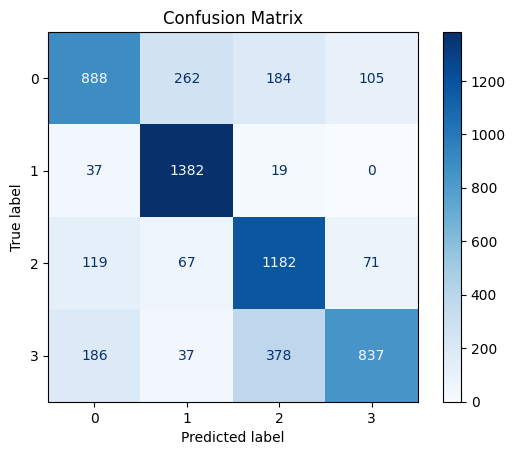


 Training Random Forest...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1439
           1       0.90      0.98      0.93      1438
           2       0.83      0.91      0.87      1439
           3       0.96      0.85      0.90      1438

    accuracy                           0.89      5754
   macro avg       0.90      0.89      0.89      5754
weighted avg       0.90      0.89      0.89      5754



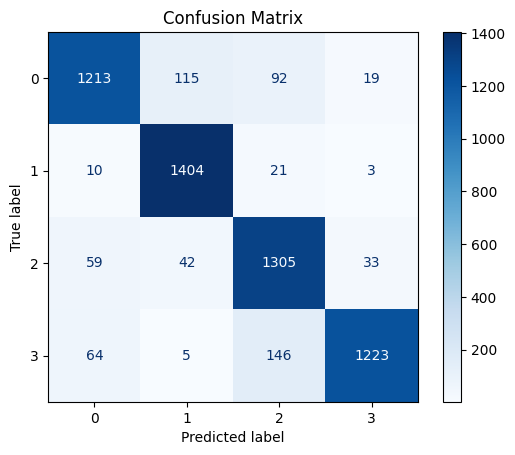


 Training XGBoost...

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1439
           1       0.93      0.97      0.95      1438
           2       0.86      0.85      0.85      1439
           3       0.92      0.86      0.89      1438

    accuracy                           0.89      5754
   macro avg       0.89      0.89      0.89      5754
weighted avg       0.89      0.89      0.89      5754



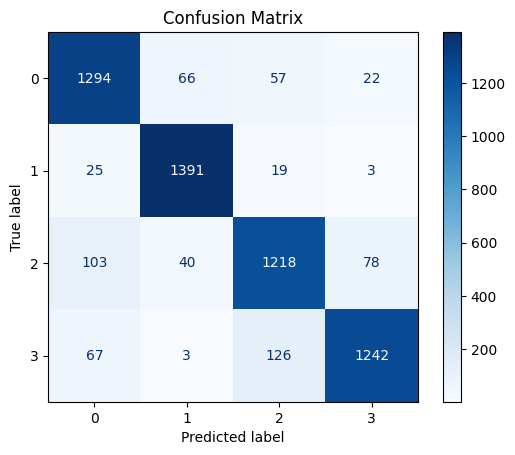

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

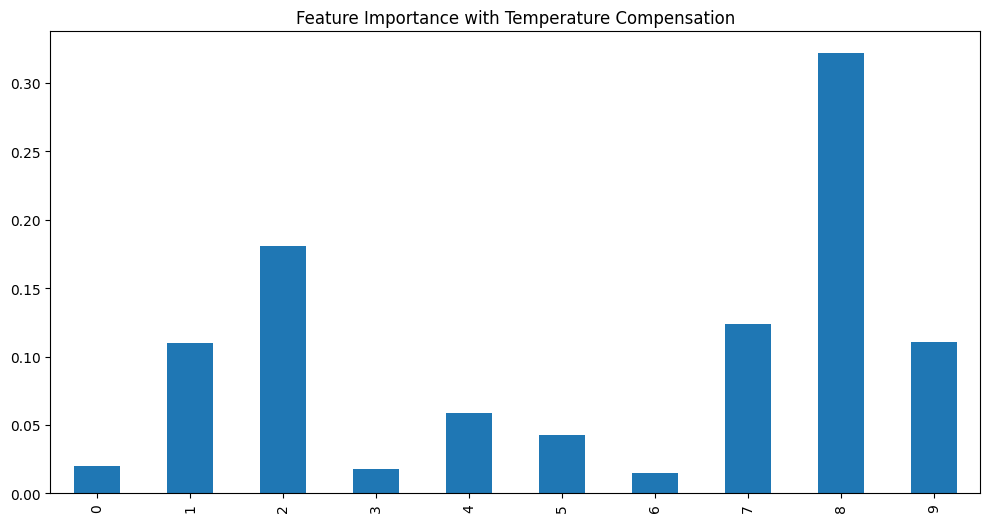

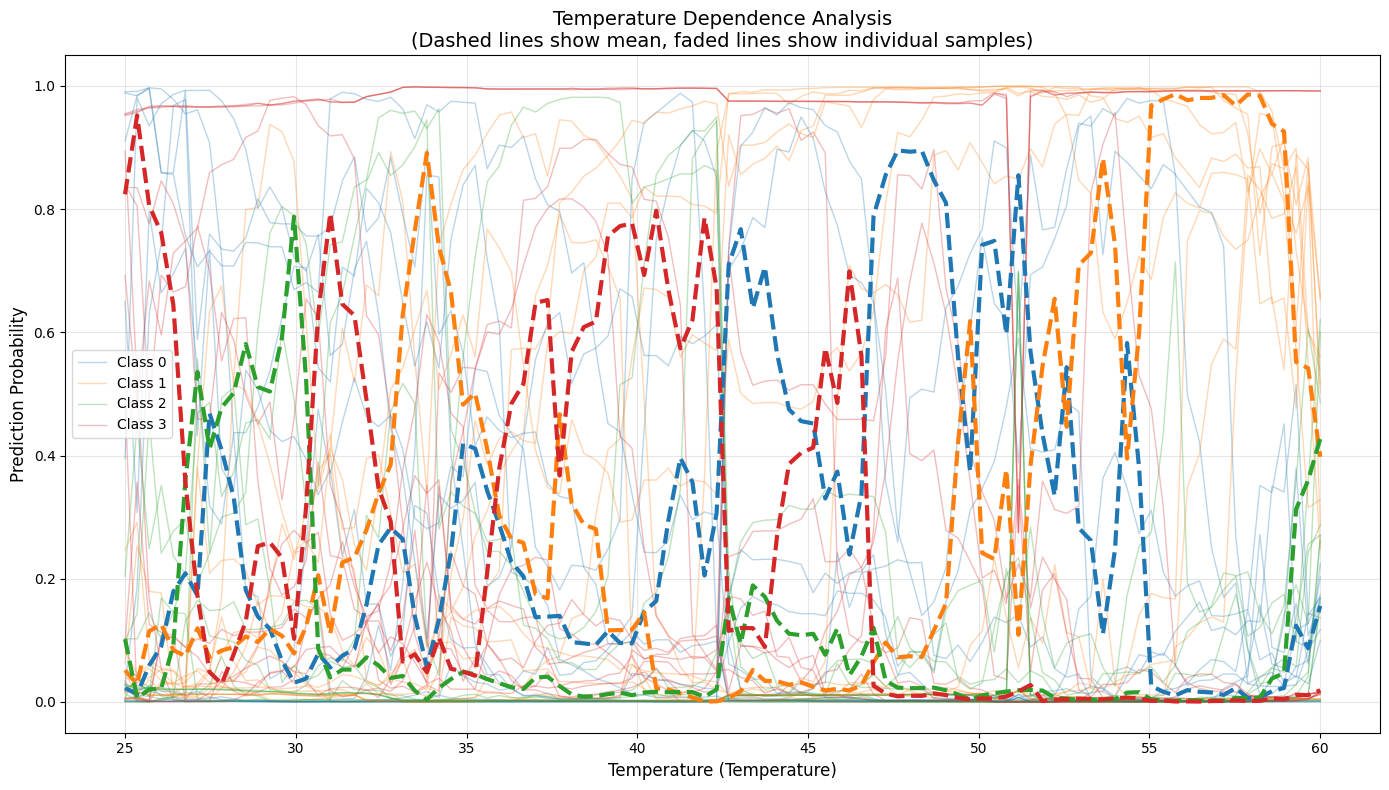


🧾 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1798
           1       0.92      0.96      0.94      1798
           2       0.86      0.85      0.85      1798
           3       0.93      0.87      0.90      1798

    accuracy                           0.89      7192
   macro avg       0.89      0.89      0.89      7192
weighted avg       0.89      0.89      0.89      7192



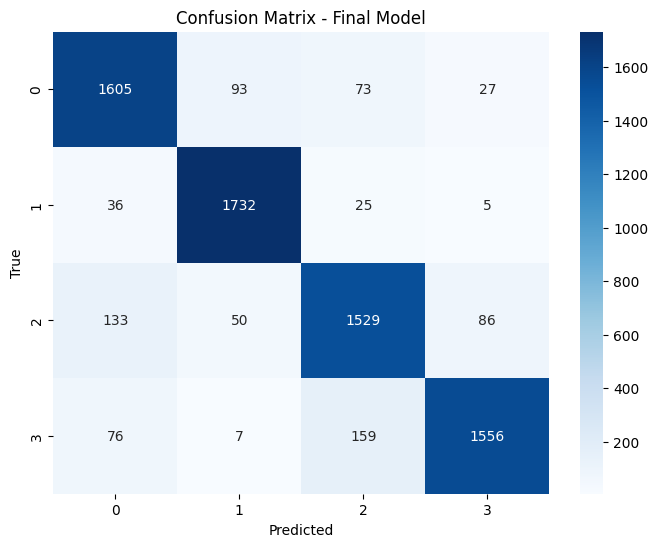


✅ Final Test Accuracy: 0.8929
🎯 Final Kappa Score: 0.8572


In [ ]:
if __name__ == "__main__":
    # Step 1: Ensure labels are integers (critical for alignment)
    df["Crack Status"] = df["Crack Status"].astype(int)  # Convert to int upfront

    # Step 2: Run the pipeline
    results_df, models, final_model, preprocessor = run_temperature_aware_pipeline(
        df,
        target_col="Crack Status",  # Fix typo if present
        temp_col="Temperature"
    )

    # Step 3: Prepare test data (use same label encoding as pipeline)
    X = df.drop(columns=["Crack Status"]).values
    y = df["Crack Status"].values  # Already integers

    # Stratified split (consistent with pipeline)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=42
    )

    # Get class names as strings for reporting
    class_names = [str(label) for label in np.unique(y)]

    # Transform test data
    X_test_trans = preprocessor.transform(X_test)

    # Predict
    y_pred = final_model.predict(X_test_trans)

    # Step 4: Reporting (aligned with working version)
    print("\n🧾 Classification Report on Test Set:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix with string labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt='d',
        xticklabels=class_names,
        yticklabels=class_names,
        cmap='Blues'
    )
    plt.title("Confusion Matrix - Final Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(f"\n✅ Final Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"🎯 Final Kappa Score: {cohen_kappa_score(y_test, y_pred):.4f}")

In [ ]:
def predict_new_data(models, preprocessor, encoder, new_data_path, original_data=None, feature_stats=None, temp_value=25.0):
    import pandas as pd
    import numpy as np
    from collections import Counter
    from sklearn.preprocessing import MinMaxScaler

    # Load and prepare new data
    new_data = pd.read_csv(new_data_path)
    print("\n Data Shape Analysis:")
    print(f"New data shape: {new_data.shape}")

    # Column setup and validation
    if new_data.shape[1] == 3:
        new_data.columns = ['Frequency', 'Real', 'Imaginary']
        new_data['Magnitude'] = np.sqrt(new_data['Real']**2 + new_data['Imaginary']**2)
        new_data['Temperature'] = temp_value
        print(f" Added Magnitude and default Temperature = {temp_value}°C.")
    elif new_data.shape[1] == 4:
        new_data.columns = ['Frequency', 'Real', 'Imaginary', 'Temperature']
        new_data['Magnitude'] = np.sqrt(new_data['Real']**2 + new_data['Imaginary']**2)
        print("Added Magnitude column from Real & Imaginary.")
    elif new_data.shape[1] == 5:
        new_data.columns = ['Frequency', 'Real', 'Imaginary', 'Magnitude', 'Temperature']

    # Input data validation
    print("\n📊 Input Data Statistics:")
    for col in ['Frequency', 'Real', 'Imaginary', 'Magnitude']:
        stats = new_data[col].describe()
        print(f"{col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.2f}")
        if new_data[col].isna().any():
            print(f"⚠️ Warning: {col} contains {new_data[col].isna().sum()} NaN values")
            new_data[col].fillna(new_data[col].mean(), inplace=True)

    # Compare distributions with original data
    if original_data is not None:
        print("\n🔍 Distribution Analysis:")
        scaler = MinMaxScaler()
        for col in ['Real', 'Imaginary', 'Magnitude']:
            orig_stats = original_data[col].describe()
            new_stats = new_data[col].describe()
            print(f"\n{col} comparison:")
            print(f"Original range: [{orig_stats['min']:.2f}, {orig_stats['max']:.2f}], mean: {orig_stats['mean']:.2f}")
            print(f"New data range: [{new_stats['min']:.2f}, {new_stats['max']:.2f}], mean: {new_stats['mean']:.2f}")

            # Calculate distribution shift
            dist_shift = abs(orig_stats['mean'] - new_stats['mean']) / (orig_stats['std'] + 1e-10)
            print(f"Distribution shift (σ): {dist_shift:.2f}")
            if dist_shift > 2:
                print("⚠️ Warning: Significant distribution shift detected!")
                # Normalize to training data range
                new_data[col] = scaler.fit_transform(new_data[[col]]) * (orig_stats['max'] - orig_stats['min']) + orig_stats['min']
                print(f"Applied range normalization to {col}")

    # Prepare features
    X_clean = new_data[['Frequency', 'Real', 'Imaginary', 'Magnitude', 'Temperature']].values
    X_clean = np.nan_to_num(X_clean, nan=0.0, posinf=1.0, neginf=-1.0)

    # Debug feature extraction
    try:
        print("\n🔧 Feature Extraction Debug:")
        X_features = preprocessor.named_steps['functiontransformer'].transform(X_clean)
        print(f"Raw features shape: {X_features.shape}")

        # Check for NaN/Inf values
        nan_count = np.isnan(X_features).sum()
        inf_count = np.isinf(X_features).sum()
        if nan_count > 0 or inf_count > 0:
            print(f"⚠️ Warning: Found {nan_count} NaN and {inf_count} Inf values in features")
            X_features = np.nan_to_num(X_features, nan=0.0, posinf=1.0, neginf=-1.0)

        # Apply processing pipeline
        X_processed = preprocessor.transform(X_clean)
        print(f"Processed features shape: {X_processed.shape}")

        # Clip extreme values
        X_processed = np.clip(X_processed, -3, 3)
        print("\nFeature value ranges after clipping:")
        print(f"Min: {X_processed.min():.2f}, Max: {X_processed.max():.2f}")

    except Exception as e:
        raise ValueError(f"Feature extraction failed: {str(e)}")

    # Feature drift validation
    validation_report = {}
    if feature_stats:
        validation_report = {
            'mean_drift': np.mean(np.abs(
                (np.mean(X_features, axis=0) - feature_stats['means']) / (feature_stats['stds'] + 1e-10)
            )),
            'range_violations': np.sum(
                (X_features < feature_stats['min']) | (X_features > feature_stats['max'])
            ) / X_features.size
        }
        print("\n🔍 Feature Validation:")
        print(f"Mean Z-score drift: {validation_report['mean_drift']:.2f}")
        print(f"% values outside training range: {validation_report['range_violations'] * 100:.1f}%")

    # Model predictions
    raw_predictions = {}
    all_preds = []

    for model_name, model in models.items():
        try:
            preds = model.predict(X_processed)
            probs = model.predict_proba(X_processed) if hasattr(model, 'predict_proba') else None

            raw_predictions[model_name] = {
                'classes': preds,
                'probabilities': probs,
                'confidence': np.max(probs, axis=1) if probs is not None else None
            }
            all_preds.append(preds)

            # Print prediction confidence
            if probs is not None:
                mean_conf = np.mean(raw_predictions[model_name]['confidence'])
                print(f"\n{model_name} mean prediction confidence: {mean_conf:.2f}")

        except Exception as e:
            print(f"⚠️ {model_name} failed: {str(e)}")

    # Majority voting with confidence weighting
    majority_vote = None
    if len(all_preds) >= 2:
        majority_vote = np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=np.array(all_preds)
        )
        print("\n Consensus Predictions:")
        for class_id, count in Counter(majority_vote).items():
            try:
                label = encoder.inverse_transform([class_id])[0]
                print(f"{label} (Class {class_id}): {count} samples")
            except:
                print(f"Class {class_id}: {count} samples")

    return {
        'raw_predictions': raw_predictions,
        'processed_features': X_processed,
        'majority_vote': majority_vote,
        'validation_report': validation_report,
        'feature_debug': {
            'raw_shape': X_features.shape,
            'processed_shape': X_processed.shape,
            'nan_count': nan_count,
            'inf_count': inf_count,
            'value_range': (X_processed.min(), X_processed.max())
        }
    }


In [ ]:
# labels = ['Healthy', 'Quarter', 'Half', 'Full']
# encoder = LabelEncoder()
# encoder.fit(labels)
# print(encoder.classes_)  # Should show ['Full', 'Half', 'Healthy', 'Quarter']
encoder = LabelEncoder().fit(df["Crack Status"])

In [ ]:
test_csv_path = '/content/TESTQUARTRCF.csv'


# Usage:
predictions = predict_new_data(
    models=models,
    preprocessor=preprocessor,
    encoder=encoder,
    new_data_path=test_csv_path,
    original_data=df,  # Pass your training dataframe here
    temp_value=30.0
)

# Individual Model Prediction Breakdown
print(" Per-Model Class Distributions:")
for model_name, result in predictions['raw_predictions'].items():
    print(f"\{model_name} Prediction Breakdown:")
    classes, counts = np.unique(result['classes'], return_counts=True)
    for cls, count in zip(classes, counts):
        label = encoder.inverse_transform([cls])[0]
        print(f" {label} (Class {cls}): {count} samples")



 Data Shape Analysis:
New data shape: (899, 3)
 Added Magnitude and default Temperature = 30.0°C.

📊 Input Data Statistics:
Frequency: min=90100.00, max=179900.00, mean=135000.00
Real: min=21.90, max=53.90, mean=34.54
⚠️ Warning: Real contains 1 NaN values
Imaginary: min=-93.30, max=-60.90, mean=-76.54
⚠️ Warning: Imaginary contains 1 NaN values
Magnitude: min=64.82, max=105.94, mean=84.19
⚠️ Warning: Magnitude contains 1 NaN values

🔍 Distribution Analysis:

Real comparison:
Original range: [9.11, 75.58], mean: 29.77
New data range: [21.90, 53.90], mean: 34.54
Distribution shift (σ): 0.37

Imaginary comparison:
Original range: [-111.82, -31.70], mean: -73.74
New data range: [-93.30, -60.90], mean: -76.54
Distribution shift (σ): 0.21

Magnitude comparison:
Original range: [41.22, 124.63], mean: 80.19
New data range: [64.82, 105.94], mean: 84.19
Distribution shift (σ): 0.26

🔧 Feature Extraction Debug:


<ipython-input-12-6b02ead93fa5>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data[col].fillna(new_data[col].mean(), inplace=True)
<ipython-input-12-6b02ead93fa5>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Raw features shape: (899, 43)
Processed features shape: (899, 10)

Feature value ranges after clipping:
Min: -3.00, Max: 3.00

SVM (RBF) mean prediction confidence: 0.86

Random Forest mean prediction confidence: 0.77

XGBoost mean prediction confidence: 0.85

 Consensus Predictions:
1 (Class 1): 816 samples
0 (Class 0): 37 samples
2 (Class 2): 22 samples
3 (Class 3): 24 samples
 Per-Model Class Distributions:
\SVM (RBF) Prediction Breakdown:
 0 (Class 0): 31 samples
 1 (Class 1): 864 samples
 2 (Class 2): 4 samples
\Random Forest Prediction Breakdown:
 0 (Class 0): 19 samples
 1 (Class 1): 814 samples
 2 (Class 2): 35 samples
 3 (Class 3): 31 samples
\XGBoost Prediction Breakdown:
 0 (Class 0): 65 samples
 1 (Class 1): 779 samples
 2 (Class 2): 20 samples
 3 (Class 3): 35 samples
